# Part2: Music Generation with RNNs

我们将在这部分建立循环神经网络(Recurrent Neural Network, RNN)用于音乐生成. 我们将用
[ABC记谱法(ABC notation)](https://en.wikipedia.org/wiki/ABC_notation) 进行乐谱的读取和输出.

由于abc记谱法转wav需要用到linux下的两个应用，而Windows下是无法使用的，所以我自己找了一个转换api，http://abcplus.sourceforge.net
在该网站上 abcmidi 部分有Windows可执行程序下载，我已将可执行文件放到与代码相同的目录下，名称为：abc2midi.exe.

以下代码以Windows系统为主，不使用Linux中外部api调用，所以无法使用 `mld.lab1.play_song()` 该方法，需要我们自己实现将abc文件转为midi文件.

## 2.1 Dependencies

首先安装课程相关库，依赖包.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download and import the MIT 6.S191 package
import mitdeeplearning as mdl

import numpy as np
import os  # 执行系统命令
import pathlib  # 文件目录操作
import IPython.display as ipythondisplay  # 将wav音频文件在浏览器中直接打开
from tqdm import tqdm  # 可视化进度条

# 确保使用的是GPU版本的tensorflow，不然训练效率很低
assert len(tf.config.list_physical_devices('GPU')) > 0

## 2.2 Dataset

使用MIT库中已经处理好的爱尔兰民谣(Irish folk songs)，以ABC记谱法表示. 下面让我们导入数据集，并查看其中的样本. 一共有 $817$ 首歌曲.

In [2]:
# 加载训练数据
songs = mdl.lab1.load_training_data()

# 查看两个曲谱
print(repr(songs[0]))
example_song = '\n\n'.join([songs[0], songs[100]])
print('\nExample song: ')
print(example_song)

Found 817 songs in text
"X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\nL:1/8\nK:D Major\n(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!\ndAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!\nAG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!\nFAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!"

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!

X:32
T:Crabs in the Skillet
Z: id:dc-jig-26
M:6/8
L:1/8
K:G Dorian
D|G3 d2F|G2A B2c|d_ed cBA|dcB AGF|!
G3 d2F|G2A B2d|c=Bc fed|cAF F2:|!
d|gag gfe|fgf fed|cde fed|cAG G2d|!
gag gfe|fgf fed|cde fed|cAF F2:|!
D|G3 A3|B3 c3|d_ed cBA|dcB AGF|!
G3 A3|B3 d3|c=Bc fed|cAF F2:|!


下面需要我们自己将abc文件转化为wav文件再通过Jupyter直接查看，要用到的相关工具我已放到 `./tools` 文件夹下了，下面编写转化代码.

In [ ]:
abc2midi_path = pathlib.Path(r'.\tools\abc2midi.exe')
midi2wav_path = pathlib.Path(r'.\tools\timidity.exe')
def play_song(song, fname='tmp'):  # 可以将字符串形式的abc记谱法，转化为wav文件，并播放出来
    for song_path in pathlib.Path.cwd().glob('*.wav'):  # 将过去生成的音乐清空
        os.remove(song_path)
    song_path = pathlib.Path(f"{fname}.abc")
    with open(song_path, 'w') as file:
        file.write(song)  # 写入到./tmp.abc文件中
    cmd = f"{abc2midi_path} {song_path}"
    ret = os.system(cmd)  # 转换 abc -> midi
    print(f"{song_path} -> midi {'Failed' if ret else 'OK'}!")
    os.remove(song_path)  # 删除./tmp.abc文件
    for i, song_path in enumerate(pathlib.Path.cwd().glob('*.mid')):  # 查找所有生成的.mid音乐
        song_name = song_path.name[:-4]  # 获取文件名前缀
        print(f"{i+1}. ", end='')
        cmd = f"{midi2wav_path} {song_name+'.mid'} -Ow {song_name+'.wav'}"
        ret = os.system(cmd)  # 转换 midi -> wav
        print(f"{song_path} -> wav {'Failed' if ret else 'OK'}!")
        ipythondisplay.display(ipythondisplay.Audio(song_name+'.wav'))  # 显示到Jupyter中
        os.remove(song_name+'.mid')  # 删除.mid文件

play_song(example_song)

这段代码已整合到 `myTools.py` 文件中，便于调用，在简化代码的文档 `Part2_Music_Generation_simplify` 中会直接调用.

接下来，我们先要得到所有曲谱中出现的字符一共有多少种. 通过Python自带的set集合可以很容易得到这个去重后的集合.

In [4]:
# 将所有的曲谱合成到一个string中
songs_joined = '\n\n'.join(songs)

# 获得所有去重后的字符
vocab = sorted(set(songs_joined))
print(f"There are {len(vocab)} unique characters in the dataset.")

# 每个字符对应的频率
vocab_num = {}
for word in vocab:
    vocab_num[word] = songs_joined.count(word)
vocab_num = sorted(vocab_num.items(), key=lambda x: x[1], reverse=True)
print(vocab_num[:10])  # 产看前十个出现频率最高的字符

There are 83 unique characters in the dataset.
[(' ', 18676), ('|', 16446), ('d', 14489), ('A', 12382), ('e', 11507), ('B', 11325), ('\n', 9437), ('2', 9217), ('G', 8325), ('c', 7971)]


## 2.3 Vectorize the text

在进入训练RNN前，我们需要将每个乐谱文本转化为对应的向量化. 为了完成这个操作，需要创建两个用于查找字典：

1. 将字符映射到数字.
2. 将数字映射到字符.

- `enumerate(seq)`：枚举函数，`seq` 为一个可迭代对象，返回 `seq` 每个元素遍历到的下标与该元素构成的tuple列表.

[Python enumerate() 函数](https://www.runoob.com/python/python-func-enumerate.html)

In [5]:
### Define numerical representation of text ###
# 字符映射到数字
char2idx = {u[0]:i for i, u in enumerate(vocab_num)}
# 数字映射到字符
idx2char = np.array([x[0] for x in vocab_num])

下面让我们看看字符集和数字的对应效果.

- `repr()` 方法可以将读取到的格式字符，比如换行符、制表符，转化为其相应的转义字符.

其中 `{repr(char):<4}` 和 `{char2idx[char]:>3}` 为 `f-string` 的格式化技巧，可以参考 [Python f-strings: Everything you need to know!
](https://datagy.io/python-f-strings/).

In [6]:
print('{')
for char,_ in zip(char2idx, range(20)):
    if _ % 5 == 0 and _ != 0:
        print()
    print(f"  {repr(char):<4}: {char2idx[char]:>3}", end=', ')
print('  ...\n}')

{
  ' ' :   0,   '|' :   1,   'd' :   2,   'A' :   3,   'e' :   4, 
  'B' :   5,   '\n':   6,   '2' :   7,   'G' :   8,   'c' :   9, 
  'f' :  10,   ':' :  11,   'g' :  12,   'a' :  13,   'F' :  14, 
  'D' :  15,   'E' :  16,   '!' :  17,   '3' :  18,   'i' :  19,   ...
}


In [7]:
### 向量化全部歌曲 ###
def vectorize_string(string):
    return np.array([char2idx[c] for c in string])

# 测试几个
print(f"A test: {vectorize_string(' |dAe')}")

vectorized_songs = vectorize_string(songs_joined)
print(f"{repr(songs_joined[:10])} --- characters mapped to int ---> {vectorized_songs[:10]}")

A test: [0 1 2 3 4]
'X:1\nT:Alex' --- characters mapped to int ---> [34 11 23  6 33 11  3 27  4 60]


## Create training examples and targets

接下来我们将从上述 `vectorized_songs` 向量化歌曲集中随机选取 `seq_length` 长度作为样本的输入特征和输出标签，假设输入特征是从 `st` 下标开始，则对应的输出标签是从 `st+1` 下标开始. 比如 `seq_length=4`，以 `Hello` 作为数据集，输入为 `Hell` 则输出为 `ello`.

再将其堆叠成batch，每个batch中有 `batch_size` 个样本.

- `np.random.choice(a, size=None, replace=True, p=None)`：`a` 为一维数组或为正整数，从一维数组 `a` 中（若 `a` 为正整数，则用 `np.arange(a)` 替代，即 $\{0,1,\cdots, a-1\}$）随机抽取 `size` 个元素组成一个一维数组；`replace` 为是否取到相同的元素，默认是可以的；`p` 为一个和 `a` 一样大小的一维数组，为提取元素所满足的概率分布，默认为均匀分布.

In [8]:
### 创建训练集的一个batch，返回样本的特征和标签 ###

def get_batch(s, seq_length, batch_size):
    # 总长度
    n = vectorized_songs.shape[0] - 1
    # 随机选取每个batch中样本下标的开始位置(依据均匀分布)
    idx = np.random.choice(n - seq_length, batch_size)
    # 构建训练集batch的特征和标签
    x_batch = np.array([s[st:st+seq_length] for st in idx])
    y_batch = np.array([s[st+1:st+seq_length+1] for st in idx])
    return x_batch, y_batch

x, y = get_batch(vectorized_songs, 10, 2)
print(f"x.shape = {x.shape}, y.shape = {y.shape}")

# 这里调用mit的测试函数，以确保上面函数没有写错
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

x.shape = (2, 10), y.shape = (2, 10)
[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


对于输入向量中的每一个，每个索引都在一个单个时间戳中处理. 我们的RNN模型都尝试预测出下一个字符的索引.

下面是一个样本中的每个单个时间戳的输入对应的输出.

In [9]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 10 ('f')
  expected output: 18 ('3')
Step   1
  input: 18 ('3')
  expected output: 2 ('d')
Step   2
  input: 2 ('d')
  expected output: 0 (' ')
Step   3
  input: 0 (' ')
  expected output: 4 ('e')
Step   4
  input: 4 ('e')
  expected output: 18 ('3')


## 2.4 The Recurrent Neural Network (RNN) model

现在我们开始构建RNN训练模型，并使用该模型生成新的乐曲. 训练数据为上面我们提取出的音乐片段.

该模型基于LSTM神经元，将该输出连接到全连接层(Dense Layer)中，最后根据输出判断下一个字符.

下面是我们将用到的几种层：

- [`tf.keras.layers.Embedding(input_dim, output_dim, mask_zero=False)`](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Embedding?hl=en)：`input_dim` 为单词库的大小；`output_dim` 为输出的维数；`mask_zero` 为布尔型，使用可变长的循环神经网络时需要用到，会将索引为0的作为掩码，在后续网络中将跳过处理（类似dropout），同时这需要后续网络都支持掩码功能. 这样做还需要一个条件，即不能将0作为特定单词的索引，而上述单词库中可以看到编号就是从1开始的，正好满足条件.

- [`tf.keras.layers.LSTM(units)`](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/LSTM?hl=en)：`units` 为一个正整数，表示输出向量的维数.

![LSTM](https://s1.ax1x.com/2022/07/27/vpE7E8.png)

### Define the RNN model
下面开始定义RNN模型.

In [10]:
def build_model(vocab_size, embedding_dim, rnn_units):
    model = keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim),
        layers.LSTM(rnn_units, return_sequences=True),
        layers.Dense(vocab_size)
    ])
    return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         21248     
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        5246976   
_________________________________________________________________
dense (Dense)                (None, None, 83)          85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### Text out the RNN model

使用一些简单的例子用来测试我们的模型建立是否正确.

In [11]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print(f"Input shape:  {x.shape} # (batch_size, sequence_length)")
print(f"Output shape: {pred.shape} # (batch_size, sequence_length, vocab_size)")

Input shape:  (32, 100) # (batch_size, sequence_length)
Output shape: (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

由于最后输出使用的是 `softmax`，

- `tf.random.categroical(logits, num_samples)`：根据categorical distribution概率分布(就是多项分布，二项分布的推广)选取出元素，`logits` 为概率分布取 `log`，`num_samples` 为取出的元素个数.

- `tf.squeeze(tensor, axis=None)`：将 `tensor` 中维数为 $1$ 维度删去，`axis` 可指定删去特定的维度.(常用于删除batch对应的层)

In [12]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
print(tf.shape(sampled_indices).numpy())
sampled_indices = tf.squeeze(sampled_indices).numpy()
print(sampled_indices.shape)

[100   1]
(100,)


我们对比下输出结果，在没训练情况下结果完全混乱的.

In [13]:
print("Input: \n", repr(''.join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'b|afef dBB2|AFF2 ABde|fedc d3|]!\n\nX:108\nT:Five Mile Chase\nZ: id:dc-reel-100\nM:C\nL:1/8\nK:G Major\nB|G2'

Next Char Predictions: 
 'Ynx(TX,JpONpI8xWfOq-AkRD>-QoR9q4q(i=6|5|INptLMRat8\n8[E<53c/OT^k=W:EhJS=gnlb<PwZ[!Nsvf<bD>A|Tc7mQAwFQ'


### 2.5 Training the model: loss and training operations

定义损失函数(Loss function)

In [14]:
def compute_loss(labels, logits):
    loss = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

example_batch_loss = compute_loss(y, pred)

print(f"Prediction shape: {pred.shape}  # (batch_size, sequence_length, vocab_size)")
print(f"scalar_loss:      {example_batch_loss.numpy().mean()}")

Prediction shape: (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:      4.418574333190918


超参数(hyperparameters)配置.

In [15]:
# Optimization parameters:
num_training_iterations = 2000
batch_size = 4  # between 1 and 64
seq_length = 100  # between 50 and 500
learning_rate = 5e-3  # between 1e-5 and 1e-1

# Model parameters:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024  # between 1 and 2048

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'my_ckpt')

定义优化器(optimizer)和训练选项，优化器建议使用 [`Adam`](https://tensorflow.google.cn/api_docs/python/tf/keras/optimizers/Adam?hl=en) 和 [`Adagrad`](https://tensorflow.google.cn/api_docs/python/tf/keras/optimizers/Adagrad?hl=en).

并且反向传播时使用 [`tf.GradientTape`](https://tensorflow.google.cn/api_docs/python/tf/GradientTape?hl=en) 进行对Loss函数进行最小化.

还需要使用 `tqdm` 输出当前模型训练的进度条.

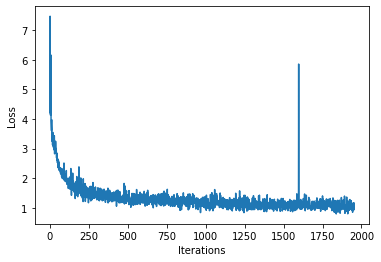

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:34<00:00, 58.17it/s]


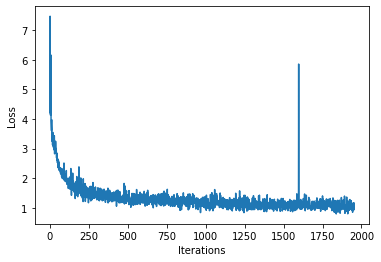

In [16]:
model = build_model(vocab_size, embedding_dim, rnn_units)
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
    # 获得训练所需的样本并进行一次传播
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)

    # 记录当前的loss，绘制图像
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # 在更新节点处保存模型
    if iter % 100 == 0:
        model.save_weights(checkpoint_prefix)

model.save_weights(checkpoint_prefix)

### Restore the latest checkpoint

这里演示如何使用储存的权重数据.

- [`model.load_weights(filepath)`](https://tensorflow.google.cn/api_docs/python/tf/keras/Model?hl=en#load_weights)：从路径 `filepath` 的TensorFlow权重文件中载入整个网络的权重.

- [`tf.train.latest_checkpoint(checkpoint_dir)`](https://tensorflow.google.cn/api_docs/python/tf/train/latest_checkpoint?hl=en)：返回最近一次的保存点保存的文件路径.

In [17]:
# 随机输出一个样本的loss，batch_size=1
def show_one_loss(model):
    x, y = get_batch(vectorized_songs, 100, 1)
    pred = model(x)
    loss = compute_loss(y, pred)
    return loss.numpy().mean()

model1 = build_model(vocab_size, embedding_dim, rnn_units)
print(f"untraining loss: {show_one_loss(model1)}")
model1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
print(f"training loss:   {show_one_loss(model1)}")

# 预测一段
print("Input: \n", repr(''.join(idx2char[x[0]])))
pred = model(x)
pred = tf.random.categorical(pred[0], num_samples=1)
pred = tf.squeeze(pred).numpy()
print("Next Char Predictions: \n", repr("".join(idx2char[pred])))

untraining loss: 4.41864013671875
training loss:   0.9809256792068481
Input: 
 'b|afef dBB2|AFF2 ABde|fedc d3|]!\n\nX:108\nT:Five Mile Chase\nZ: id:dc-reel-100\nM:C\nL:1/8\nK:G Major\nB|G2'
Next Char Predictions: 
 "ggfdc g3B2|AdD2 ABde|]2cB Bc:]!\n\nX:191\nT:Tere Togv'Laurs\nZ: id:dc-heel-101\nM:C\nL:1/8\nK:G Major\nG|ABG"


## 2.6 Generate music using the RNN model

### The prediction procedure

为了使得步骤简单，我们使用batch_size=1进行预测. 使用代码生成ABC记谱法的音乐格式.

- 初始化RNN状态需要一个启动序列"seed"，不能从无开始直接进行生成，然后设定我们期望生成序列的长度.

- 使用启动序列通过RNN的输出得到一个概率分布，根据该分布得到下一个字符的预测.

- 使用多项分布计算每个预测的字符，该预测的字符将作为模型中下一个输入.

- 由于将上一次的输出作为下一次预测的输入，所以RNN是可以根据具有之前相关信息进行预测的.

![prediction](https://s2.loli.net/2022/07/27/iDFBm6Pnbwga3lh.png)

In [21]:
def generate_text(model, start_string, generation_length=1000):
    input_eval = vectorize_string(start_string)

    text_generated = []
    model.reset_states()
    for i in tqdm(range(generation_length)):
        pred = model(input_eval.reshape(1, -1))
        pred = tf.squeeze(pred, 0)  # 将batch层删去
        pred_id = tf.random.categorical(pred, num_samples=1)[-1, 0].numpy()  # 取出下标数字
        input_eval = np.array([pred_id])  # 作为下一个预测值的输入
        text_generated.append(idx2char[pred_id])
    return (start_string +  ''.join(text_generated))

generated_text = generate_text(model, start_string='X', generation_length=1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.77it/s]


### Play back the generated music

In [ ]:
play_song(generated_text)